## <u>**Preliminary Cells**</u>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("e_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("e_data/data'+number+'.csv")'
        exec(new_string)
        df = 'df'+number
        new_df = locals()[df]
        df_list.append(new_df)
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(item)
            
band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2,.05])
    return my_fit[1]

In [19]:
spec_list = []
for number in new_array:
    my_string = 'spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

time_list_i = []
for number in new_array:
    my_string = 'ettime'+number+' = df'+number+"['ettime']"
    exec(my_string)
    time = 'ettime'+number
    time_list_i.append(locals()[time])

time_list_f = []
for df in time_list_i:
    for time in df:
        time_list_f.append(time)

total_spectrum = []
for spec in spec_list:
    for spectrum in spec:
        total_spectrum.append(spectrum)

total_spectrum = np.asarray(total_spectrum)
total_spectrum_2 = dc(total_spectrum)
print('List 1: '+str(np.shape(total_spectrum)))
print('List 2 (Copy): '+str(np.shape(total_spectrum_2))) # Confirms that DeepCopy works correctly

List 1: (12655, 256)
List 2 (Copy): (12655, 256)


### **Beyond this point:**
Filter spectra in two different ways

Filtering within 3 $\sigma$
- Utilize ```sc.signal.find_peaks()```

### **PRIOR TO MEDIAN MAPPING**

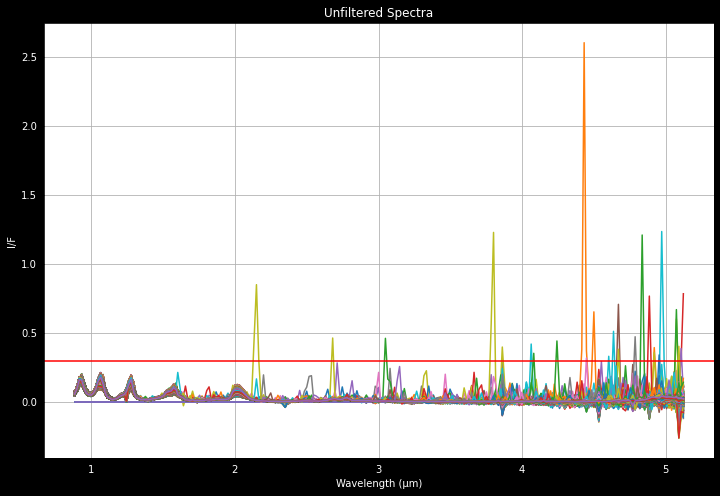

In [3]:
%matplotlib inline
plt.figure(facecolor='black',figsize=(12,8))
plt.title('Unfiltered Spectra',color='white')
for spectrum in total_spectrum:
    plt.plot(vims_wave,spectrum)
plt.axhline(y=0.3,color='r',linestyle='-')
plt.xticks(color='white')
plt.xlabel('Wavelength (µm)',color='white')
plt.yticks(color='white')
plt.ylabel('I/F',color='White')
plt.grid()
plt.show()

#### **Note: Forgot to use channel 0 in initial filtering, which is what causes the weird behavior at ```vims_wave[0]``` in ```cleaning_3.ipynb```**

In [20]:
for (i,j) in zip(range(0,258),range(1,257)): # Start with channel 0 NOT channel 1
    median = np.median(total_spectrum[:,i:j])
    vals = total_spectrum_2[:,i:j]
    std = np.std(total_spectrum[:,i:j])
    ind = np.where(np.abs(vals-median)>3*std) # 3 STD as benchmark as the DISTANCE from the value of the indice to the median value at that same channel
    vals[ind] = median

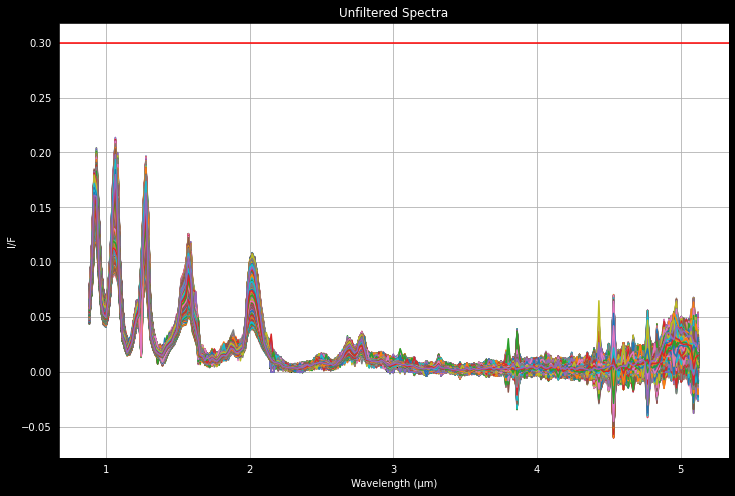

In [5]:
%matplotlib inline
plt.figure(facecolor='black',figsize=(12,8))
plt.title('Unfiltered Spectra',color='white')
for spectrum in total_spectrum_2:
    plt.plot(vims_wave,spectrum)
plt.axhline(y=0.3,color='r',linestyle='-')
plt.xticks(color='white')
plt.xlabel('Wavelength (µm)',color='white')
plt.yticks(color='white')
plt.ylabel('I/F',color='White')
plt.grid()
plt.show()

#### **Now look at ```sc.signal.find_peaks()``` to handle the peaks past 3.5 µm (```vims_wave[158:256]```)**

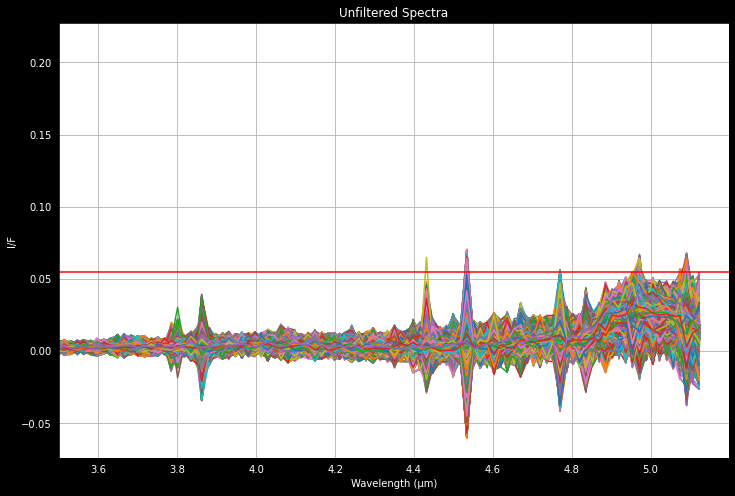

In [7]:
%matplotlib inline
plt.figure(facecolor='black',figsize=(12,8))
plt.title('Unfiltered Spectra',color='white')
for spectrum in total_spectrum_2:
    plt.plot(vims_wave,spectrum)
plt.axhline(y=0.055,color='r',linestyle='-')
plt.xticks(color='white')
plt.xlim([3.5,vims_wave[255]+0.075])
plt.xlabel('Wavelength (µm)',color='white')
plt.yticks(color='white')
plt.ylabel('I/F',color='white')
plt.grid()
plt.show()

### **Example use of ```find_peaks()``` on spectra #4125**

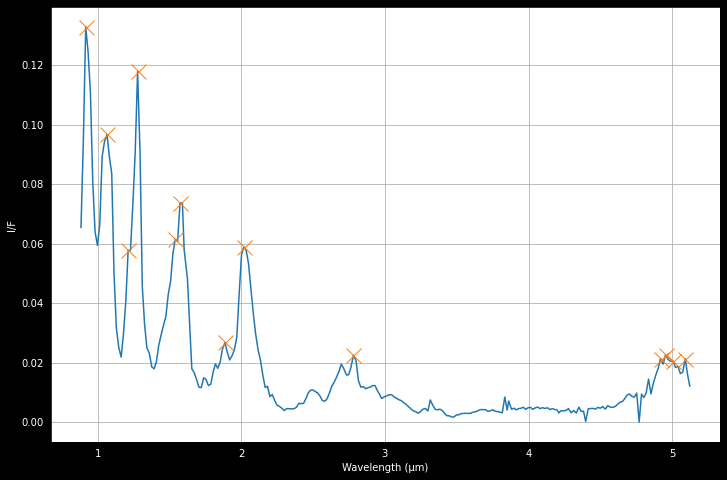

In [9]:
peaks, _ = find_peaks(total_spectrum_2[4125],height=[0.02 or 0.12])
%matplotlib inline
plt.figure(facecolor='black',figsize=(12,8))
plt.plot(vims_wave,total_spectrum_2[4125])
plt.plot(vims_wave[peaks],total_spectrum_2[4125,peaks],'x',markersize=15)
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel('Wavelength (µm)',color='white')
plt.ylabel('I/F',color='white')
plt.grid()
plt.show()

### **Usage with every spectra with the same process following ```total_spectrum_2[4125]```**

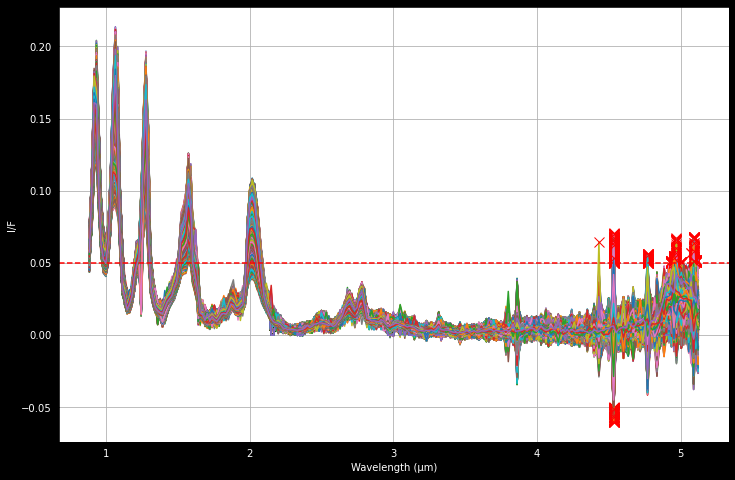

In [10]:
%matplotlib inline
plt.figure(facecolor='black',figsize=(12,8))
for spectrum in total_spectrum_2:
    peaks, _ = find_peaks(np.abs(spectrum[158:256]),height=0.05) # np.abs() works for both positive and negative values
    peaks = peaks+158
    plt.plot(vims_wave,spectrum)
    plt.plot(vims_wave[peaks],spectrum[peaks],'x',color='red',markersize=10)
plt.axhline(y=0.05,color='red',linestyle='--')
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel('Wavelength (µm)',color='white')
plt.ylabel('I/F',color='white')
plt.grid()
plt.show()

### **<u>Flagging spectra with peaks identified by previous code</u>**

In [21]:
bad_spectra = []
for index,spectrum in enumerate(total_spectrum_2):
    peaks, _ = find_peaks(np.abs(spectrum[158:256]),height=0.05)
    peaks = peaks+158
    if len(peaks) > 0:
        bad_spectra.append(index) # Adds WHERE the Spectra are in the list and NOT the arrays themselves

print(np.shape(bad_spectra))

(602,)


### **Filtering spectrum in ```flagged[] list```**

In [27]:
for (i,j) in zip(range(158,258),range(159,257)):
    median = np.median(total_spectrum_2[:,i:j])
    vals = total_spectrum_2[bad_spectra,i:j]
    std = np.std(total_spectrum_2[:,i:j])
    ind = np.where(np.abs(vals-median)>.25*std)
    vals[ind] = median

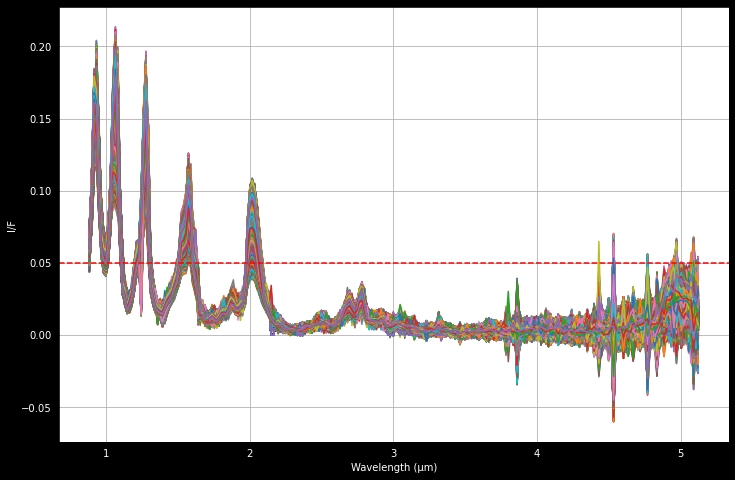

In [30]:
%matplotlib inline
plt.figure(facecolor='black',figsize=(12,8))
for spectrum in total_spectrum_2:
    plt.plot(vims_wave,spectrum)
plt.axhline(y=0.05,color='red',linestyle='--')
plt.xticks(color='white')
plt.yticks(color='white')
plt.xlabel('Wavelength (µm)',color='white')
plt.ylabel('I/F',color='white')
plt.grid()
plt.show()